In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys
import tinyarray

In [117]:
# armchair edges

t=1.0
t_sc=0.5

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])


def make_system(W=200, L=200, gn=0, m=0.1, mu=0.6, phi=0):
            
    def qh_slab(pos):
        (x, y) = pos 
        return (-L <= x <= L) and (-W <= y < W)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         # modulated hopping in x direction
        H1=-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj))
        return np.kron(H1,np.eye(2))
   
    def onsite(site, mu ,gn):
        return  - mu*np.eye(2) - gn* tau_z
    
    def onsiteA(site, m, mu ,gn):
        return  (m- mu)*np.eye(2) - gn* tau_z
    
    def onsiteB(site, m, mu, gn):
        return  -(m+ mu)*np.eye(2)- gn* tau_z

    
    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3)/2, 1/2), (0, 1)],
                                [(-1/sqrt(12), -0.5), (1/sqrt(12), -0.5)],norbs=2)
    subA, subB= lat.sublattices
    syst = kwant.Builder()
#     syst[lat.shape(qh_slab, (0,0))] = onsite
    syst[subA.shape(qh_slab, (0,0))] = onsiteA
    syst[subB.shape(qh_slab, (0,0))] = onsiteB
    syst[lat.neighbors()] = hopping_ab


    sym_right = kwant.TranslationalSymmetry(lat.vec((2, -1)))
    right_lead = kwant.Builder(sym_right)
#     right_lead[lat.shape(qh_slab, (0,0))] = onsite
    right_lead[subA.shape(qh_slab, (0,0))] = onsiteA
    right_lead[subB.shape(qh_slab, (0,0))] = onsiteB
    right_lead[lat.neighbors()] = hopping_ab
    
    syst.attach_lead(right_lead)
    syst.attach_lead(right_lead.reversed())

    
    return syst

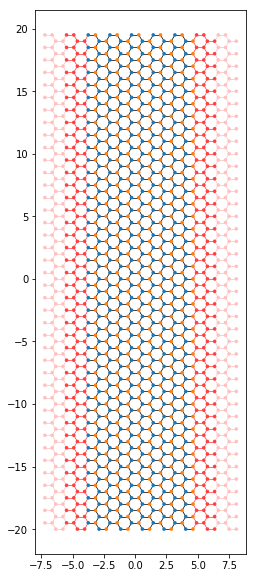

In [128]:
# Wsc must be multiples of eight
W=20
L=4
syst = make_system(W=W, L=L)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(40,10),num_lead_cells=2)
# kwant.plot(syst,num_lead_cells=1)
# Finalize the system.
syst = syst.finalized()

In [125]:
mu=0.18
m=0.0
gn=0.04
# momenta = [-pi + 0.02 * pi * i for i in range(101)]
momenta= np.linspace(-1,1,601)*pi
def plot_wf(phi=0):
    params=dict(m=m, mu=mu, gn=gn, phi=phi, momenta=momenta)
    fig = plt.figure()  # create a figure object
    ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
    ax1.set_ylim(-0.5,0.5)
    plt.grid()
    plt.title(r'$\phi=$ %.3f' % (phi))
    plt.show()
    
# interact(plot_wf, phi=(0, 0.01, 0.001));

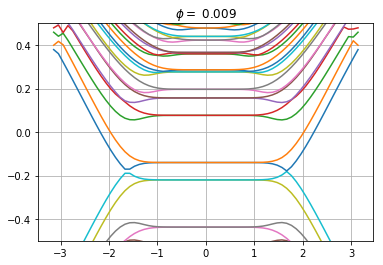

In [126]:
plot_wf(phi=0.0095)

[0.8660254 0.5      ] [0. 1.]


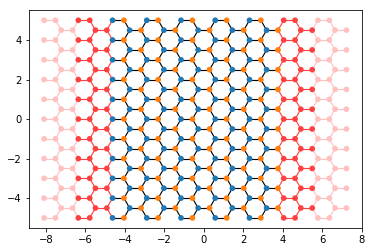

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:78: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/tmp/yes/lib/python3.7/site-packages/kwant/plotter.py:1409: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  ham = syst.cell_hamiltonian(args, params=params)
/tmp/yes/lib/python3.7/site-packages/kwant/system.py:274: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  sparse=sparse, params=params)
/tmp/yes/lib/python3.7/site-packages/kwant/plotter.py:1412: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  _hop = syst.inter_cell_hopping(args, params=params)
/tmp/yes/lib/pytho

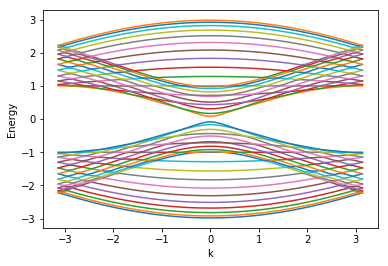

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:85: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/tmp/yes/lib/python3.7/site-packages/kwant/solvers/common.py:164: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  params=params)[:2]
/tmp/yes/lib/python3.7/site-packages/kwant/solvers/common.py:191: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
/tmp/yes/lib/python3.7/site-packages/kwant/system.py:305: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  ham = self.cell_hamiltonian(args, params=params)
/tmp/yes/lib/pyt

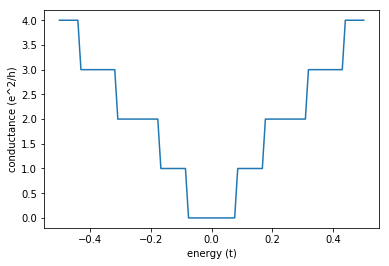

In [54]:
from math import sqrt
import random
import itertools as it
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import kwant

class Honeycomb(kwant.lattice.Polyatomic):
    """Honeycomb lattice with methods for dealing with hexagons"""

    def __init__(self, name=''):
        prim_vecs = [[sqrt(3)/2, 0.5], [0, 1]]  # bravais lattice vectors
        # offset the lattice so that it is symmetric around x and y axes
        basis_vecs = [[-1/sqrt(12), -0.5], [1/sqrt(12), -0.5]]
        super(Honeycomb, self).__init__(prim_vecs, basis_vecs, name)
        self.a, self.b = self.sublattices

    def hexagon(self, tag):
        """ Get sites belonging to hexagon with the given tag.
            Returns sites in counter-clockwise order starting
            from the lower-left site.
        """
        tag = ta.array(tag)
        #         a-sites b-sites
        deltas = [(0, 0), (0, 0),
                  (1, 0), (0, 1),
                  (0, 1), (-1, 1)]
        lats = it.cycle(self.sublattices)
        return (lat(*(tag + delta)) for lat, delta in zip(lats, deltas))

    def hexagon_neighbors(self, tag, n=1):
        """ Get n'th nearest neighbor hoppings within the hexagon with
            the given tag.
        """
        hex_sites = list(self.hexagon(tag))
        return ((hex_sites[(i+n)%6], hex_sites[i%6]) for i in xrange(6))

def ribbon(W, L):
    def shape(pos):
        return (-L <= pos[0] <= L and -W <= pos[1] <= W)
    return shape

def onsite_potential(site, params):
    return params['ep']

def kinetic(site_i, site_j, params):
    return -params['gamma']


lat = Honeycomb()
pv1, pv2 = lat.prim_vecs
print(pv1,pv2)
xsym = kwant.TranslationalSymmetry(pv2 - 2*pv1)  # lattice symmetry in -x direction
ysym = kwant.TranslationalSymmetry(-pv2)  # lattice symmetry in -y direction

def create_lead_h(W, symmetry, axis=(0, 0)):
    lead = kwant.Builder(symmetry)
    lead[lat.wire(axis, W)] = 0.
    lead[lat.neighbors(1)] = kinetic
    return lead

def create_system(W, L):
    ## scattering region ##
    sys = kwant.Builder()
    sys[lat.shape(ribbon(W, L), (0, 0))] = onsite_potential
    sys[lat.neighbors(1)] = kinetic

    ## leads ##
    leads = [create_lead_h(W, xsym)]
    leads += [lead.reversed() for lead in leads]  # right lead
    for lead in leads:
        sys.attach_lead(lead)
    return sys

def plot_bands(sys):
    fsys = sys.finalized()
    kwant.plotter.bands(fsys.leads[0], args=(dict(gamma=1., ep=0.),))

def plot_conductance(sys, energies):
    fsys = sys.finalized()
    data = []

    for energy in energies:
        smatrix = kwant.smatrix(fsys, energy, args=(dict(gamma=1., ep=0.),))
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy (t)")
    plt.ylabel("conductance (e^2/h)")
    plt.show()

if __name__ == '__main__':
    sys = create_system(5, 4)
    kwant.plot(sys)
    plot_bands(sys)
    
    Es = np.linspace(-0.5, 0.5, 100)
    plot_conductance(sys, Es)